In [5]:
import pandas as pd
import numpy as np

In [3]:
#SNIPPET 7.1 Purging Observations

def get_train_times(t1: pd.Series, testTimes: pd.Series) -> pd.Series:
    """
    Given test times, find the times of the training observations

        Parameters:
            t1 : pd.Series
            testTimes : pd.Series
        Returns:
            train pd.Series: series with purged observations from the training set
    """
    train = t1.copy(deep=True)
    for start, end in testTimes.iteritems():
        df0 = train[(start <= train.index) & (train.index <= end)].index
        df1 = train[(start <= train) & (train <= end)].index
        df2 = train[(train.index <= start) & (end <= train)].index
        train = train.drop(df0.union(df1).union(df2))
    return train

In [6]:
#SNIPPET 7.2 Embargo 

def get_embargo_times(times: np.ndarray, pctEmbargo: float = 0.0) -> pd.Series:
    '''
    Get embargo time for each bar
        Parameters:
            times: np.ndarray: timestamps of bars
            pctEmbargo: float: Share of observations to drop after test
            
        Returns:
            mbrg pd.Series: series with bar timestamps (mbrg.index) and embargo time for each bar (mbrg.value)
    '''
    step = int(times.shape[0] * pctEmbargo)
    if step == 0:
        mbrg = pd.Series(times, index=times)
    else:
        mbrg = pd.Series(times[step:], index=times[:-step])
        mbrg = mbrg.append(pd.Series(times[-1], index=times[-step:]))
    return mbrg

In [13]:
#SNIPPET 7.2 DV Class with Overlap
from sklearn.model_selection import KFold
from typing import Optional, Tuple, Generator, Any
class PurgedKFold(KFold):
    """
    Extend KFold class to work with labels that span intervals.
    The train is purged of observations overlapping test-label intervals.
    Test set is assumed to be contiguous (shuffle=False), without training samples in between.
    """

    def __init__(self, n_splits: int = 3, t1: Optional[pd.Series] = None, pctEmbargo=0.0) -> None:
        if not isinstance(t1, pd.Series) and t1 is not None:
            raise ValueError("t1 must be a pd.Series")
        super(PurgedKFold, self).__init__(n_splits, shuffle=False, random_state=None)
        self.t1 = t1
        self.pctEmbargo = pctEmbargo

    def split(self, X: pd.DataFrame, y: Optional[pd.Series] = None, groups: Optional[pd.Series] = None) -> Generator[Tuple[np.ndarray, np.ndarray], None, None]:
        if (X.index==self.t1.index).sum() != len(self.t1):
            raise ValueError("X and t1 must have the same index")
        indices = np.arange(X.shape[0])
        mbrg = int(X.shape[0] * self.pctEmbargo)
        test_starts = [(i[0], i[-1] + 1) for i in np.array_split(np.arange(X.shape[0]), self.n_splits)]
        for i, j in test_starts:
            t0 =self.t1.index[i]
            test_indices = indices[i:j]
            maxT1Idx = self.t1.index.searchsorted(self.t1[test_indices].max())
            train_indices = self.t1.index.searchsorted(self.t1[self.t1 <= t0].index)
            if maxT1Idx < X.shape[0]:
                train_indices = np.concatenate((train_indices, indices[maxT1Idx + mbrg:]))
            yield train_indices, test_indices

In [21]:
#SNIPPET 7.4 Using the PurgedKFold Class
# necessary to avoid gugs with "classes_" and 'sample_weight' attributes in some sklearn implementation
from sklearn.metrics import log_loss, accuracy_score
def cvScore(
    clf: Any, X: pd.DataFrame, y: pd.Series, sample_weight: Optional[pd.Series] = None, scoring: str = 'neg_log_loss',
    t1: Optional[pd.Series] = None, cv: Optional[int] = None,
    cvGen: Optional[PurgedKFold] = None, pctEmbargo: float = None) -> np.ndarray:
    """
    Compute the cross-validated score of a classifier

        Parameters:
            clf : Any: classifier object
            X : pd.DataFrame: feature set
            y : pd.Series: labels

        Returns:
            score np.ndarray: array with cross-validated scores
    """
    if scoring not in ['neg_log_loss', 'accuracy']:
        raise ValueError("scoring must be 'neg_log_loss' or 'accuracy'")
    if cvGen is None:
       cvGen = PrurgedKFold(n_splits=cv, t1=t1, pctEmbargo=pctEmbargo)
    score = []
    for train, test in cvGen.split(X=X):
        fit = clf.fit(X.iloc[train], y.iloc[train], sample_weight=sample_weight.iloc[train].values)
        if scoring == 'neg_log_loss':
            prob = clf.predict_proba(X.iloc[test, :])
            score_ = -log_loss(y.iloc[test], prob, sample_weight=sample_weight.iloc[test].values, labels=clf.classes_)
        else:
            pred = fit.predict_proba(X.iloc[test, :])
            score_ = accuracy_score(y.iloc[test], pred, sample_weight=sample_weight.iloc[test].values)
        score.append(score_) 
    return np.array(score)


In [16]:
#Simulated Data
np.random.seed(42)
n_samples = 100
dates = pd.date_range(start='2022-01-01', periods=n_samples, freq='D')

#Features
X = pd.DataFrame({
    'feature1': np.random.randn(n_samples),
    'feature2': np.random.randn(n_samples)
}, index=dates)

# Binary Labels
y = pd.Series(np.random.choice([0, 1], size=n_samples), index=dates)

# Sumulated event span (t1): each label is assumed valud for the next 5 days
t1 = pd.Series(dates + pd.Timedelta(days=5), index=dates)

# Sample Weights
sample_weight = pd.Series(np.ones(len(y)), index=dates)

X.head(10)

,feature1,feature2
2022-01-01,0.496714,-1.415371
2022-01-02,-0.138264,-0.420645
2022-01-03,0.647689,-0.342715
2022-01-04,1.523030,-0.802277
2022-01-05,-0.234153,-0.161286
2022-01-06,-0.234137,0.404051
2022-01-07,1.579213,1.886186
2022-01-08,0.767435,0.174578
2022-01-09,-0.469474,0.257550
2022-01-10,0.542560,-0.074446


In [22]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

cv = PurgedKFold(n_splits=5, t1=t1, pctEmbargo=0.01)

#Run CV
scores = cvScore(clf, X, y, sample_weight=sample_weight, scoring='neg_log_loss', t1=t1, cvGen=cv)

print(f"PurgedKFold CV log loss: {np.round(np.mean(scores), 4)} +/- {np.round(np.std(scores), 4)}")

PurgedKFold CV log loss: -0.8414 +/- 0.1819


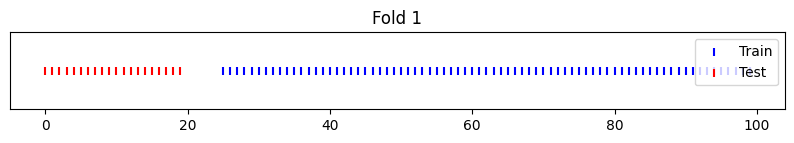

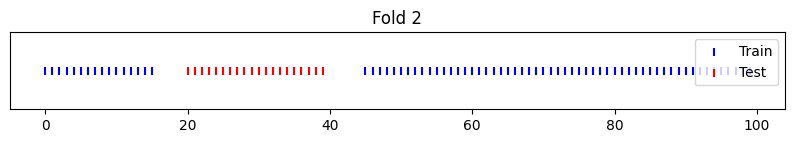

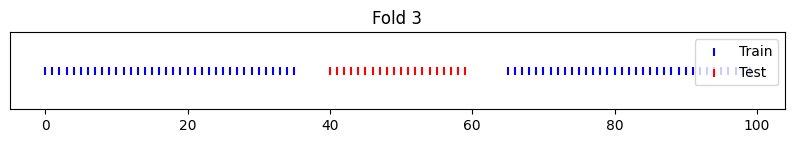

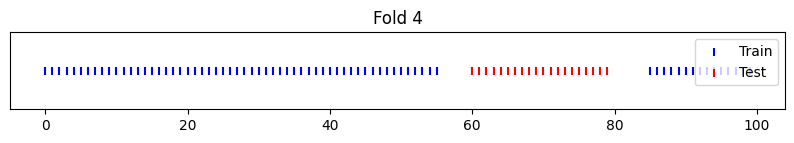

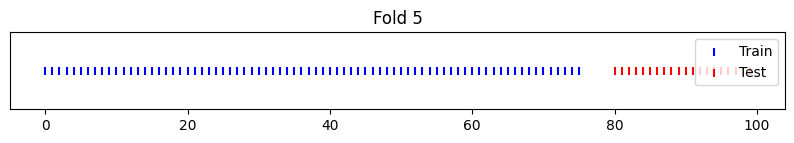

In [25]:
import matplotlib.pyplot as plt
for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
    plt.figure(figsize=(10, 1))
    plt.scatter(train_idx, [1]*len(train_idx), label='Train', color='blue', marker='|')
    plt.scatter(test_idx, [1]*len(test_idx), label='Test', color='red', marker='|')
    plt.title(f'Fold {i+1}')
    plt.yticks([])
    plt.legend()
    plt.show()




In [26]:
for fold, (train_idx, test_idx) in enumerate(cv.split(X=X)):

    print(f"Fold {fold + 1}:")
    print(f"  Test indices: {test_idx[0]} to {test_idx[-1]} ")

    test_start = t1.index[test_idx[0]]
    test_end = t1[test_idx].max()

    all_indices = np.arange(X.shape[0])

    purge_mask = (
        ((t1.index >= test_start) & (t1.index <= test_end)) |
        ((t1 >= test_start) & (t1 <= test_end)) |
        ((t1.index <= test_start) & (t1 >= test_end))
    )

    purged_indices = all_indices[purge_mask.values]

    embargo_size = int(X.shape[0] * cv.pctEmbargo)
    last_test_idx = test_idx[-1]
    embargoed_indices = np.arange(last_test_idx + 1, min(last_test_idx + 1 + embargo_size, X.shape[0]))

    final_train = np.setdiff1d(all_indices, np.concatenate((test_idx, purged_indices, embargoed_indices)))

    print(f" - Total train before purge: {len(all_indices)}")
    print(f" - Purged due to overlap: {purged_indices}")
    print(f" - Embargoed: {embargoed_indices}")
    print(f" - Final train used: {final_train}")




Fold 1:
  Test indices: 0 to 19 
 - Total train before purge: 100
 - Purged due to overlap: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
 - Embargoed: [20]
 - Final train used: [25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97 98 99]
Fold 2:
  Test indices: 20 to 39 
 - Total train before purge: 100
 - Purged due to overlap: [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38
 39 40 41 42 43 44]
 - Embargoed: [40]
 - Final train used: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77
 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]
Fold 3:
  Test indices: 40 to 59 
 - Total train before purge: 100
 - Purged due to overlap: [35 36 37 38 39 40 41 42 43